In [ ]:
!pip install umap-learn

In [ ]:
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

#for visualisation
from sklearn.tree import export_graphviz
import graphviz

import umap

In [ ]:
pd.set_option('display.max_columns', None)
# pd.set_option("max_rows", 300)
# return
# pd.reset_option(“max_columns”)

In [ ]:
column_names = ['surgery?', 'Age', 'Hospital Number', 'rectal temperature', 'pulse', 'respiratory rate',
                'temperature of extremities', 'peripheral pulse', 'mucous membranes', 'capillary refill time', 'pain',
                'peristalsis', 'abdominal distension', 'nasogastric tube', 'nasogastric reflux',
                'nasogastric reflux PH', 'rectal examination - feces', 'abdomen', 'packed cell volume', 'total protein',
                'abdominocentesis appearance', 'abdomcentesis total protein', 'outcome', 'surgical lesion?',
                'site of lesion', 'type of lesion', 'subtype', 'cp_data']

In [ ]:
len(column_names)

28

Processing and reading

In [ ]:
processed_data = []

with open('horse-colic.data', 'r') as file:
  for line in file:
    row = line.strip().split(' ')
    processed_data.append(row)

df = pd.DataFrame(processed_data, columns = column_names)

In [ ]:
df.head()

,surgery?,Age,Hospital Number,rectal temperature,pulse,respiratory rate,temperature of extremities,peripheral pulse,mucous membranes,capillary refill time,pain,peristalsis,abdominal distension,nasogastric tube,nasogastric reflux,nasogastric reflux PH,rectal examination - feces,abdomen,packed cell volume,total protein,abdominocentesis appearance,abdomcentesis total protein,outcome,surgical lesion?,site of lesion,type of lesion,subtype,cp_data
0,2,1,530101,38.50,66,28,3,3,?,2,5,4,4,?,?,?,3,5,45.00,8.40,?,?,2,2,11300,00000,00000,2
1,1,1,534817,39.2,88,20,?,?,4,1,3,4,2,?,?,?,4,2,50,85,2,2,3,2,02208,00000,00000,2
2,2,1,530334,38.30,40,24,1,1,3,1,3,3,1,?,?,?,1,1,33.00,6.70,?,?,1,2,00000,00000,00000,1
3,1,9,5290409,39.10,164,84,4,1,6,2,2,4,4,1,2,5.00,3,?,48.00,7.20,3,5.30,2,1,02208,00000,00000,1
4,2,1,530255,37.30,104,35,?,?,6,2,?,?,?,?,?,?,?,?,74.00,7.40,?,?,2,2,04300,00000,00000,2


delete useless columns

In [ ]:
df.drop(columns = ['Hospital Number', 'subtype', 'type of lesion'], inplace = True)

In [ ]:
df.head()

,surgery?,Age,rectal temperature,pulse,respiratory rate,temperature of extremities,peripheral pulse,mucous membranes,capillary refill time,pain,peristalsis,abdominal distension,nasogastric tube,nasogastric reflux,nasogastric reflux PH,rectal examination - feces,abdomen,packed cell volume,total protein,abdominocentesis appearance,abdomcentesis total protein,outcome,surgical lesion?,site of lesion,cp_data
0,2,1,38.50,66,28,3,3,?,2,5,4,4,?,?,?,3,5,45.00,8.40,?,?,2,2,11300,2
1,1,1,39.2,88,20,?,?,4,1,3,4,2,?,?,?,4,2,50,85,2,2,3,2,02208,2
2,2,1,38.30,40,24,1,1,3,1,3,3,1,?,?,?,1,1,33.00,6.70,?,?,1,2,00000,1
3,1,9,39.10,164,84,4,1,6,2,2,4,4,1,2,5.00,3,?,48.00,7.20,3,5.30,2,1,02208,1
4,2,1,37.30,104,35,?,?,6,2,?,?,?,?,?,?,?,?,74.00,7.40,?,?,2,2,04300,2


Work with '?' in numerical values. Changing all '?' in numeric columns on mean of column



In [ ]:
df_num = df[['rectal temperature', 'pulse', 'respiratory rate', 'nasogastric reflux PH', 'packed cell volume',
             'total protein', 'abdomcentesis total protein']]

count = 0
for col in df_num:
  clear_column =  df_num[df_num[col] != '?'][col]
  mean_col = clear_column.astype(float).mean()
  for i in range(0, len(df_num[col])):
    if df_num[col][i] == '?':
      df_num[col][i] = mean_col

<ipython-input-12-c514a6c21bf6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[col][i] = mean_col


One hot encoder to categorical values (column with ? we can just drop)

In [ ]:
df_cat = df[[item for item in df.columns if item not in ['rectal temperature', 'pulse', 'respiratory rate', 'nasogastric reflux PH', 'packed cell volume', 'total protein', 'abdomcentesis total protein']]]


In [ ]:
df_cat.columns

Index(['surgery?', 'Age', 'temperature of extremities', 'peripheral pulse',
       'mucous membranes', 'capillary refill time', 'pain', 'peristalsis',
       'abdominal distension', 'nasogastric tube', 'nasogastric reflux',
       'rectal examination - feces', 'abdomen', 'abdominocentesis appearance',
       'outcome', 'surgical lesion?', 'site of lesion', 'cp_data'],
      dtype='object')

Divide binar and categorical values for one hot encoder

In [ ]:
df_binar = df_cat[['Age', 'cp_data', 'surgical lesion?']]

df_cat = df_cat[[item for item in df_cat.columns if item not in df_binar.columns]]

In [ ]:
df_cat.head()

,surgery?,temperature of extremities,peripheral pulse,mucous membranes,capillary refill time,pain,peristalsis,abdominal distension,nasogastric tube,nasogastric reflux,rectal examination - feces,abdomen,abdominocentesis appearance,outcome,site of lesion
0,2,3,3,?,2,5,4,4,?,?,3,5,?,2,11300
1,1,?,?,4,1,3,4,2,?,?,4,2,2,3,02208
2,2,1,1,3,1,3,3,1,?,?,1,1,?,1,00000
3,1,4,1,6,2,2,4,4,1,2,3,?,3,2,02208
4,2,?,?,6,2,?,?,?,?,?,?,?,?,2,04300


In [ ]:
df_cat = pd.get_dummies(df_cat)

Remove all columns with '?'

In [ ]:
df_cat.drop(columns = ['surgery?_?', 'temperature of extremities_?', 'peripheral pulse_?', 'capillary refill time_?',
                      'pain_?', 'peristalsis_?', 'abdominal distension_?', 'nasogastric tube_?', 'nasogastric reflux_?',
                      'rectal examination - feces_?', 'abdomen_?', 'abdominocentesis appearance_?', 'outcome_?'], inplace = True)

Concate tables

In [ ]:
dff = pd.concat([df_binar, df_num, df_cat], axis=1)

In [ ]:
dff.head()

,Age,cp_data,surgical lesion?,rectal temperature,pulse,respiratory rate,nasogastric reflux PH,packed cell volume,total protein,abdomcentesis total protein,surgery?_1,surgery?_2,temperature of extremities_1,temperature of extremities_2,temperature of extremities_3,temperature of extremities_4,peripheral pulse_1,peripheral pulse_2,peripheral pulse_3,peripheral pulse_4,mucous membranes_1,mucous membranes_2,mucous membranes_3,mucous membranes_4,mucous membranes_5,mucous membranes_6,mucous membranes_?,capillary refill time_1,capillary refill time_2,capillary refill time_3,pain_1,pain_2,pain_3,pain_4,pain_5,peristalsis_1,peristalsis_2,peristalsis_3,peristalsis_4,abdominal distension_1,abdominal distension_2,abdominal distension_3,abdominal distension_4,nasogastric tube_1,nasogastric tube_2,nasogastric tube_3,nasogastric reflux_1,nasogastric reflux_2,nasogastric reflux_3,rectal examination - feces_1,rectal examination - feces_2,rectal examination - feces_3,rectal examination - feces_4,abdomen_1,abdomen_2,abdomen_3,abdomen_4,abdomen_5,abdominocentesis appearance_1,abdominocentesis appearance_2,abdominocentesis appearance_3,outcome_1,outcome_2,outcome_3,site of lesion_00000,site of lesion_00300,site of lesion_00400,site of lesion_01111,site of lesion_01124,site of lesion_01400,site of lesion_02111,site of lesion_02112,site of lesion_02113,site of lesion_02124,site of lesion_02205,site of lesion_02206,site of lesion_02207,site of lesion_02208,site of lesion_02209,site of lesion_02300,site of lesion_02305,site of lesion_02322,site of lesion_03025,site of lesion_03111,site of lesion_03112,site of lesion_03113,site of lesion_03115,site of lesion_03124,site of lesion_03133,site of lesion_03205,site of lesion_03207,site of lesion_03209,site of lesion_03300,site of lesion_03400,site of lesion_04111,site of lesion_04122,site of lesion_04124,site of lesion_04205,site of lesion_04206,site of lesion_04207,site of lesion_04300,site of lesion_05000,site of lesion_05111,site of lesion_05124,site of lesion_05205,site of lesion_05206,site of lesion_05400,site of lesion_06111,site of lesion_06112,site of lesion_06209,site of lesion_07111,site of lesion_07113,site of lesion_07209,site of lesion_07400,site of lesion_08300,site of lesion_08400,site of lesion_09000,site of lesion_09400,site of lesion_11124,site of lesion_11300,site of lesion_11400,site of lesion_12208,site of lesion_21110,site of lesion_31110,site of lesion_41110
0,1,2,2,38.50,66,28,4.707547,45.00,8.40,3.019608,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,2,2,39.2,88,20,4.707547,50,85,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,2,38.30,40,24,4.707547,33.00,6.70,3.019608,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,1,1,39.10,164,84,5.00,48.00,7.20,5.30,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2,2,37.30,104,35,4.707547,74.00,7.40,3.019608,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
dff.shape

(300, 125)

After processing data and removing all missing values (?), let's use algorythms

#SVM - classification

In [ ]:
dff.columns

Index(['Age', 'cp_data', 'surgical lesion?', 'rectal temperature', 'pulse',
       'respiratory rate', 'nasogastric reflux PH', 'packed cell volume',
       'total protein', 'abdomcentesis total protein',
       ...
       'site of lesion_08400', 'site of lesion_09000', 'site of lesion_09400',
       'site of lesion_11124', 'site of lesion_11300', 'site of lesion_11400',
       'site of lesion_12208', 'site of lesion_21110', 'site of lesion_31110',
       'site of lesion_41110'],
      dtype='object', length=125)

In [ ]:
X = dff.drop(['surgery?_1', 'surgery?_2'], axis = 1)

y = dff['surgery?_1']

<Axes: >

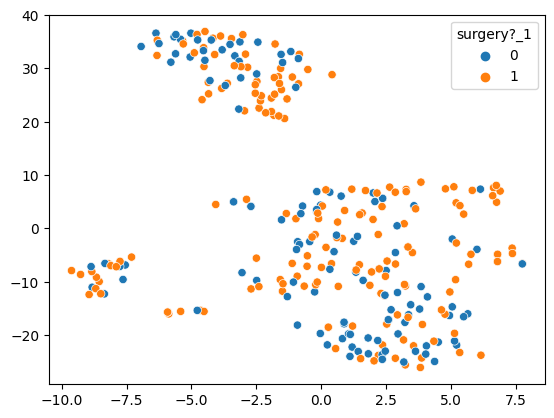

In [ ]:
X_embedded = TSNE(n_components = 2, perplexity = 28).fit_transform(X)

x_emb = X_embedded[:, 0]
y_emb = X_embedded[:, 1]

sns.scatterplot(x = x_emb, y = y_emb, hue = y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train.shape, X_test.shape

((240, 123), (60, 123))

In [ ]:
cols = X_train.columns

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [ ]:
X_test = pd.DataFrame(X_test, columns=[cols])

#Rbf kernel

In [ ]:
svc = SVC()
svc.fit(X_train,y_train)

y_pred=svc.predict(X_test)
print('Model accuracy score with C = 1: {}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with C = 1: 0.8166666666666667


In [ ]:
#Checking overfitting and underfitting
y_pred_train = svc.predict(X_train)
print(accuracy_score(y_train, y_pred_train))

0.925


In [ ]:
X_train.shape

(240, 123)

In [ ]:
svc.support_vectors_.shape

(208, 123)

<Axes: >

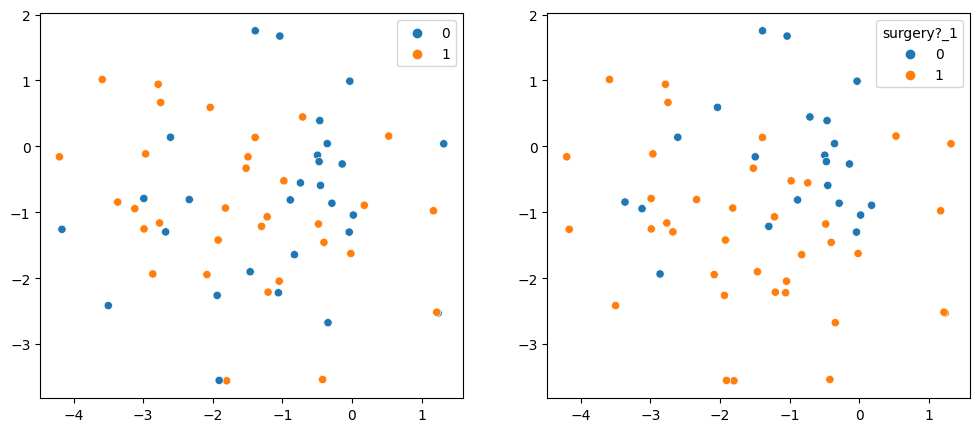

In [ ]:
X_embedded = TSNE(n_components = 2).fit_transform(X_test)
x_emb = X_embedded[:, 0]
y_emb = X_embedded[:, 1]

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x = x_emb, y = y_emb, hue = y_pred)

plt.subplot(1, 2, 2)
sns.scatterplot(x = x_emb, y = y_emb, hue = y_test)

In [ ]:
svc = SVC(C = 2.0)
svc.fit(X_train,y_train)

y_pred=svc.predict(X_test)
print('Model accuracy score with C = 2: {}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with C = 2: 0.8166666666666667


In [ ]:
#Checking overfitting and underfitting
y_pred_train = svc.predict(X_train)
print(accuracy_score(y_train, y_pred_train))

0.9708333333333333


As we can see, the most reliable model is first with C = 1

#Linear kernel

In [ ]:
linear_svc = SVC(kernel = 'linear')
linear_svc.fit(X_train,y_train)
y_pred=linear_svc.predict(X_test)
print('Model accuracy score with C = 1: {}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with C = 1: 0.6833333333333333


In [ ]:
y_pred_train = linear_svc.predict(X_train)
print(accuracy_score(y_train, y_pred_train))

0.9875


In [ ]:
linear_svc.support_vectors_.shape

(93, 123)

<Axes: >

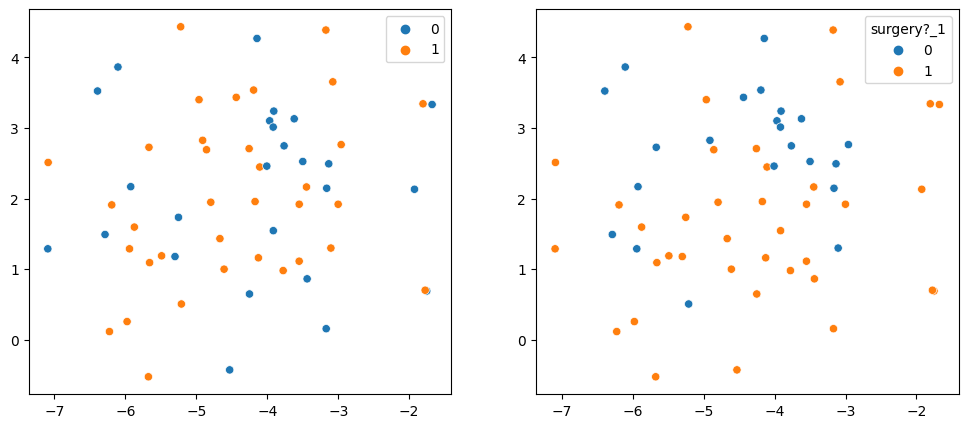

In [ ]:
X_embedded = TSNE(n_components = 2).fit_transform(X_test)
x_emb = X_embedded[:, 0]
y_emb = X_embedded[:, 1]

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x = x_emb, y = y_emb, hue = y_pred)

plt.subplot(1, 2, 2)
sns.scatterplot(x = x_emb, y = y_emb, hue = y_test)

In [ ]:
linear_svc = SVC(kernel = 'linear', C = 2)
linear_svc.fit(X_train,y_train)
y_pred=linear_svc.predict(X_test)
print('Model accuracy score with C = 2: {}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with C = 2: 0.6333333333333333


In [ ]:
y_pred_train = linear_svc.predict(X_train)
print(accuracy_score(y_train, y_pred_train))

1.0


In [ ]:
linear_svc.support_vectors_.shape

(88, 123)

Model with C = 1 is the best among other linear kernel models. But this model is weak.

#Polynomial kernel

In [ ]:
poly_svc = SVC(kernel = 'poly', C = 1.0)

poly_svc.fit(X_train, y_train)
y_pred = poly_svc.predict(X_test)

print('Model accuracy score with C = 1: {}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with C = 1: 0.6833333333333333


In [ ]:
y_pred_train = poly_svc.predict(X_train)
print(accuracy_score(y_train, y_pred_train))

0.7583333333333333


In [ ]:
poly_svc_best = SVC(kernel = 'poly', C = 4.0)

poly_svc_best.fit(X_train, y_train)
y_pred_poly_best = poly_svc_best.predict(X_test)

print('Model accuracy score with C = 4: {}'.format(accuracy_score(y_test, y_pred_poly_best)))

Model accuracy score with C = 4: 0.85


In [ ]:
y_pred_train = poly_svc_best.predict(X_train)

print(accuracy_score(y_train, y_pred_train))

0.9875


<Axes: >

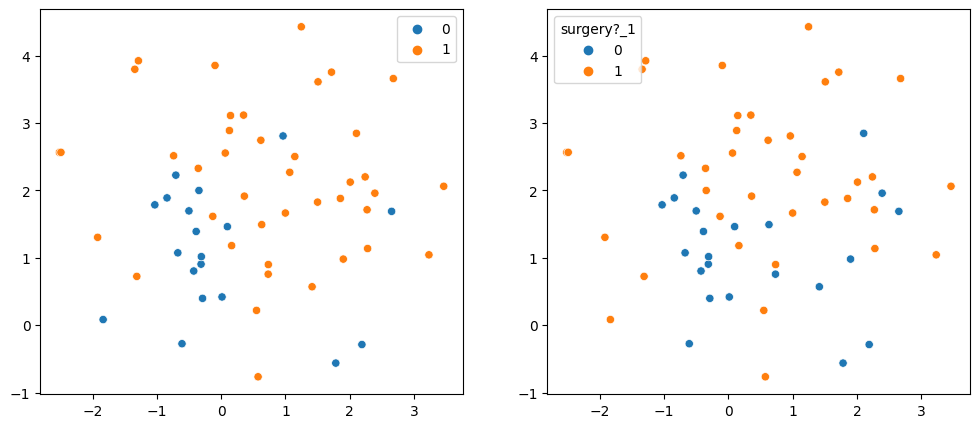

In [ ]:
X_embedded = TSNE(n_components = 2).fit_transform(X_test)
x_emb = X_embedded[:, 0]
y_emb = X_embedded[:, 1]

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x = x_emb, y = y_emb, hue = y_pred_poly_best)

plt.subplot(1, 2, 2)
sns.scatterplot(x = x_emb, y = y_emb, hue = y_test)

In [ ]:
poly_svc = SVC(kernel = 'poly', C = 5.0)

poly_svc.fit(X_train, y_train)
y_pred = poly_svc.predict(X_test)

print('Model accuracy score with C = 5: {}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with C = 5: 0.85


In [ ]:
y_pred_train = poly_svc.predict(X_train)

print(accuracy_score(y_train, y_pred_train))

0.9916666666666667


Last model is overfitted,
hence best score for model with C = 4

#Sigmoid kernel

In [ ]:
sigmoid_svc_best = SVC(kernel = 'sigmoid', C = 1.0)

sigmoid_svc_best.fit(X_train, y_train)
y_pred_sigmoid_best = sigmoid_svc_best.predict(X_test)

print('Model accuracy score with C = 1: {}'.format(accuracy_score(y_test, y_pred_sigmoid_best)))

Model accuracy score with C = 1: 0.85


<Axes: >

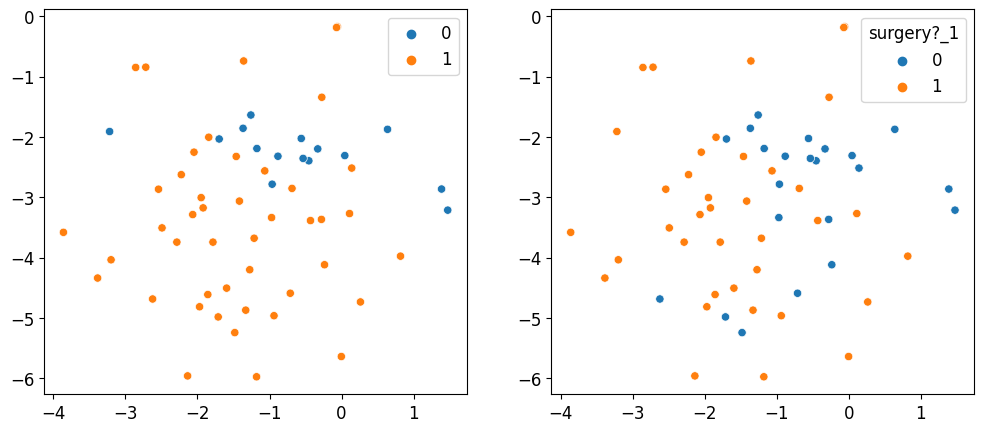

In [ ]:
X_embedded = TSNE(n_components = 2).fit_transform(X_test)
x_emb = X_embedded[:, 0]
y_emb = X_embedded[:, 1]

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x = x_emb, y = y_emb, hue = y_pred_sigmoid_best)

plt.subplot(1, 2, 2)
sns.scatterplot(x = x_emb, y = y_emb, hue = y_test)

In [ ]:
sigmoid_svc = SVC(kernel = 'sigmoid', C = 2)

sigmoid_svc.fit(X_train, y_train)
y_pred = sigmoid_svc.predict(X_test)

print('Model accuracy score with C = 1: {}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with C = 1: 0.8166666666666667


In [ ]:
y_pred_train = poly_svc.predict(X_train)

print(accuracy_score(y_train, y_pred_train))

0.9916666666666667


Best score is shown by model with C = 1

Best Scores:

Sigmoid:
  test = 0.85
  train = 0.99167

Poly:
  test = 0.85
  train = 0.929167

Linear:
  test = 0.6833
  train = 0.9875

RBF:
  test = 0.816
  train = 0.925


Let's choose two best models (it's models with sigmoid and poly kernels). And let's move to metrics evaluations. And choose the best model.

#Metrics

In [ ]:
# y_pred_poly_best
# y_pred_sigmoid_best

cm_poly = confusion_matrix(y_test, y_pred_poly_best)
cm_sigmoid = confusion_matrix(y_test, y_pred_sigmoid_best)

print('Confusion matrix with poly kernel\n\n', cm_poly)

print('\n\nConfusion matrix with sigmoid kernel\n\n', cm_sigmoid)


Confusion matrix with poly kernel

 [[16  6]
 [ 3 35]]


Confusion matrix with sigmoid kernel

 [[14  8]
 [ 1 37]]


In [ ]:
TP_p = cm_poly[0,0]
TN_p = cm_poly[1,1]
FP_p = cm_poly[0,1]
FN_p = cm_poly[1,0]

TP_s = cm_sigmoid[0,0]
TN_s = cm_sigmoid[1,1]
FP_s = cm_sigmoid[0,1]
FN_s = cm_sigmoid[1,0]


In [ ]:
print(classification_report(y_test, y_pred_poly_best))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78        22
           1       0.85      0.92      0.89        38

    accuracy                           0.85        60
   macro avg       0.85      0.82      0.83        60
weighted avg       0.85      0.85      0.85        60



In [ ]:
print(classification_report(y_test, y_pred_sigmoid_best))

              precision    recall  f1-score   support

           0       0.93      0.64      0.76        22
           1       0.82      0.97      0.89        38

    accuracy                           0.85        60
   macro avg       0.88      0.81      0.82        60
weighted avg       0.86      0.85      0.84        60



In [ ]:
classification_accuracy = (TP_p + TN_p) / float(TP_p + TN_p + FP_p + FN_p)
print('Classification accuracy (poly) : {}'.format(classification_accuracy))

classification_accuracy = (TP_s + TN_s) / float(TP_s + TN_s + FP_s + FN_s)
print('\nClassification accuracy (sigmoid) : {}'.format(classification_accuracy))

Classification accuracy (poly) : 0.85

Classification accuracy (sigmoid) : 0.85


In [ ]:
classification_error = (FP_p + FN_p) / float(TP_p + TN_p + FP_p + FN_p)
print('Classification error : {}'.format(classification_error))

classification_error = (FP_s + FN_s) / float(TP_s + TN_s + FP_s + FN_s)
print('Classification error : {}'.format(classification_error))

Classification error : 0.15
Classification error : 0.15


True Positive Rate (Recall)

In [ ]:
true_positive_rate = TP_p / float(TP_p + FN_p)
print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

true_positive_rate = TP_s / float(TP_s + FN_s)
print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

True Positive Rate : 0.8421
True Positive Rate : 0.9333


False Positive Rate



In [ ]:
false_positive_rate = FP_p / float(FP_p + TN_p)
print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

false_positive_rate = FP_s / float(FP_s + TN_s)
print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

False Positive Rate : 0.1463
False Positive Rate : 0.1778


Specificity

In [ ]:
specificity = TN_p / (TN_p + FP_p)
print('Specificity : {0:0.4f}'.format(specificity))

specificity = TN_s / (TN_s + FP_s)
print('Specificity : {0:0.4f}'.format(specificity))

Specificity : 0.8537
Specificity : 0.8222


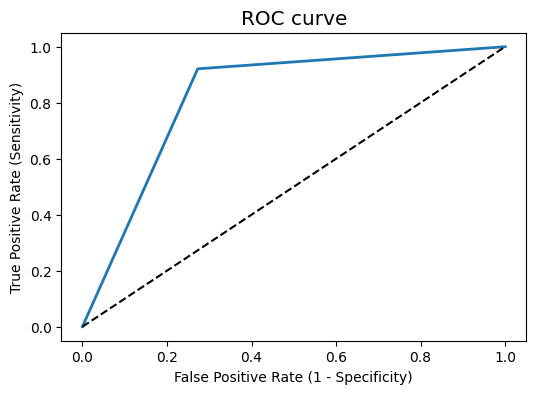

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_poly_best)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

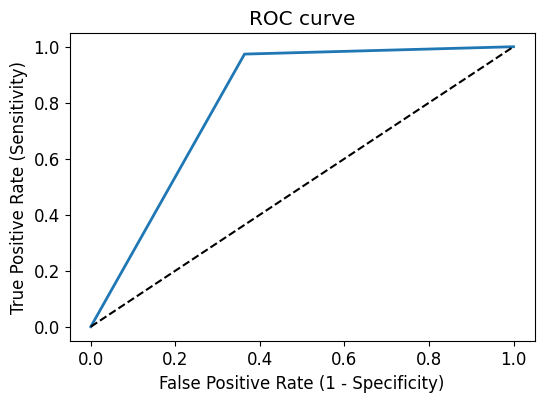

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_sigmoid_best)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

In [ ]:
fpr, tpr

(array([0.        , 0.36363636, 1.        ]),
 array([0.        , 0.97368421, 1.        ]))

In [ ]:
ROC_AUC = roc_auc_score(y_test, y_pred_poly_best)
print('ROC AUC (poly) : {:.4f}'.format(ROC_AUC))

ROC_AUC = roc_auc_score(y_test, y_pred_sigmoid_best)
print('ROC AUC (sigmoid) : {:.4f}'.format(ROC_AUC))

ROC AUC (poly) : 0.8242
ROC AUC (sigmoid) : 0.8050


In [ ]:
Cross_validated_ROC_AUC = cross_val_score(poly_svc_best, X, y, cv=10, scoring='roc_auc').mean()
print('Cross validated ROC AUC (poly) : {:.4f}'.format(Cross_validated_ROC_AUC))

Cross_validated_ROC_AUC = cross_val_score(sigmoid_svc_best, X, y, cv=10, scoring='roc_auc').mean()
print('Cross validated ROC AUC (sigmoid): {:.4f}'.format(Cross_validated_ROC_AUC))

Cross validated ROC AUC (poly) : 0.7171
Cross validated ROC AUC (sigmoid): 0.4528


we see that on the straight roc auc score poly is better, but using cross validation we expose that sigmoid has better results

In [ ]:
# Стратифицированная классификация проводится, если обьем таргетов не пропорционален (это не то немного)
y_test.value_counts()
y_train.value_counts()

1    142
0     98
Name: surgery?_1, dtype: int64

In [ ]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)

poly_scores = cross_val_score(poly_svc_best, X, y, cv=kfold)

sigmoid_scores = cross_val_score(sigmoid_svc_best, X, y, cv=kfold)

In [ ]:
poly_scores.mean()

0.6

In [ ]:
sigmoid_scores.mean()

0.5333333333333334

Grid Search

In [ ]:
svc=SVC()


parameters = [ {'C':[1, 2, 3,4, 5, 10], 'kernel':['linear']},
               {'C':[1, 2, 3,4, 5, 10], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 2, 3,4, 5, 10], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]},
               {'C':[1, 2, 3,4, 5, 10], 'kernel':['sigmoid'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]}
              ]

grid_search = GridSearchCV(estimator = svc,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 2, 3, 4, 5, 10], 'kernel': ['linear']},
                         {'C': [1, 2, 3, 4, 5, 10],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [1, 2, 3, 4, 5, 10], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['poly']},
                         {'C': [1, 2, 3, 4, 5, 10], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['sigmoid']}],
             scoring='accuracy')

In [ ]:
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.8000


Parameters that give the best results : 

 {'C': 1, 'degree': 2, 'gamma': 0.02, 'kernel': 'sigmoid'}


Estimator that was chosen by the search : 

 SVC(C=1, degree=2, gamma=0.02, kernel='sigmoid')


In [ ]:
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

GridSearch CV score on test set: 0.8333


My thoughts about model were right. Model with sigmoid kernel the best

#KNN classification

In [ ]:
knn = KNeighborsClassifier(metric='cosine', n_neighbors=19, weights='distance')

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.7666666666666667


In [ ]:
k_values = [i for i in range(1, 31)]

scores = []

for k in k_values:

  knn = KNeighborsClassifier(n_neighbors=k)

  score = cross_val_score(knn, X, y, cv = 5)

  scores.append(np.mean(score))


Text(0, 0.5, 'Accuracy Score')

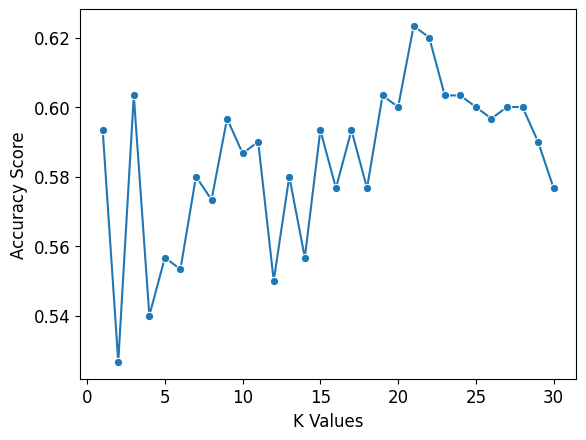

In [ ]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        22
           1       0.80      0.84      0.82        38

    accuracy                           0.77        60
   macro avg       0.75      0.74      0.74        60
weighted avg       0.76      0.77      0.76        60



In [ ]:
knn=KNeighborsClassifier()


parameters = [{ 'n_neighbors' : [i for i in range(0, 31)],
               'metric':['manhattan', 'chebyshev', 'minkowski', 'cosine', 'euclidean'],
                'weights' : ['distance', 'uniform']}]

grid_search = GridSearchCV(estimator = knn,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 1550.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 213, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sk

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['manhattan', 'chebyshev', 'minkowski',
                                     'cosine', 'euclidean'],
                          'n_neighbors': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                          12, 13, 14, 15, 16, 17, 18, 19, 20,
                                          21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                          'weights': ['distance', 'uniform']}],
             scoring='accuracy')

In [ ]:
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.7667


Parameters that give the best results : 

 {'metric': 'cosine', 'n_neighbors': 19, 'weights': 'distance'}


Estimator that was chosen by the search : 

 KNeighborsClassifier(metric='cosine', n_neighbors=19, weights='distance')


In [ ]:
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

GridSearch CV score on test set: 0.7667


<Axes: >

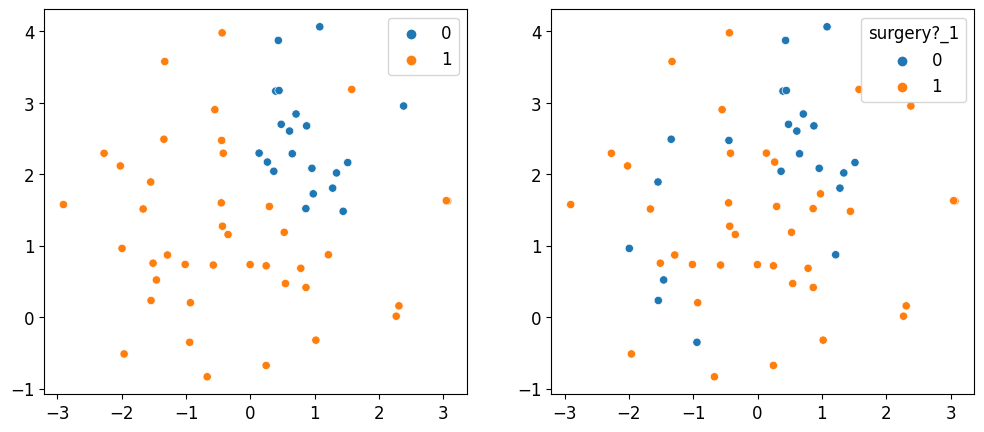

In [ ]:
X_embedded = TSNE(n_components = 2).fit_transform(X_test)
x_emb = X_embedded[:, 0]
y_emb = X_embedded[:, 1]

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x = x_emb, y = y_emb, hue = y_pred)

plt.subplot(1, 2, 2)
sns.scatterplot(x = x_emb, y = y_emb, hue = y_test)

#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 0)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.8500


In [ ]:
rfc_100 = RandomForestClassifier(n_estimators = 13, random_state = 0)

rfc_100.fit(X_train, y_train)

y_pred = rfc_100.predict(X_test)

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 100 decision-trees : 0.8000


Delete all unusefull columns and will do it again

In [ ]:
feature_scores = pd.Series(rfc_100.feature_importances_, index = X_train.columns).sort_values(ascending = False)

feature_scores

surgical lesion?        0.120527
pulse                   0.089680
site of lesion_00000    0.056954
rectal temperature      0.056368
total protein           0.053935
                          ...   
site of lesion_03025    0.000000
site of lesion_03209    0.000000
site of lesion_03207    0.000000
site of lesion_03115    0.000000
site of lesion_03300    0.000000
Length: 123, dtype: float64

In [ ]:
feature_scores = feature_scores[feature_scores<0.01]

feature_scores

In [ ]:
#columns to delete
del_col = feature_scores.index.tolist()

del_col = [item[0] for item in del_col]


In [ ]:
X_train_n = X_train.drop(del_col, axis = 1)
X_test_n = X_test.drop(del_col, axis = 1)

<ipython-input-133-a6724230b952>:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train_n = X_train.drop(del_col, axis = 1)
<ipython-input-133-a6724230b952>:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_test_n = X_test.drop(del_col, axis = 1)


In [ ]:
X_train_n.shape

(240, 29)

In [ ]:
X_test_n.shape

(60, 29)

In [ ]:
rfc_new = RandomForestClassifier(n_estimators = 16, random_state = 0)

rfc_new.fit(X_train_n, y_train)

y_pred = rfc_new.predict(X_test_n)

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 100 decision-trees : 0.8667


Visualisation

In [ ]:
for i in range(3):
    tree = rfc_new.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train_n.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        22
           1       0.86      0.95      0.90        38

    accuracy                           0.87        60
   macro avg       0.87      0.84      0.85        60
weighted avg       0.87      0.87      0.86        60



In [ ]:
rfc_gs=RandomForestClassifier()

lst_estim = list(range(1,10))
lst_estim.extend([15, 20, 25, 30, 100, 200, 300, 400, 500, 600, 700, 800, 900])


parameters = [{ 'n_estimators' : lst_estim,
               'max_depth':[10, 20, 30, 40, 50],
                'bootstrap' : [True, False]}]

grid_search = GridSearchCV(estimator = rfc_gs,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

grid_search.fit(X_train_n, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [10, 20, 30, 40, 50],
                          'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 20,
                                           25, 30, 100, 200, 300, 400, 500, 600,
                                           700, 800, 900]}],
             scoring='accuracy')

In [ ]:
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))


GridSearch CV best score : 0.8542


Parameters that give the best results : 

 {'bootstrap': False, 'max_depth': 40, 'n_estimators': 100}


Estimator that was chosen by the search : 

 RandomForestClassifier(bootstrap=False, max_depth=40)


In [ ]:
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test_n, y_test)))

GridSearch CV score on test set: 0.8667


<Axes: >

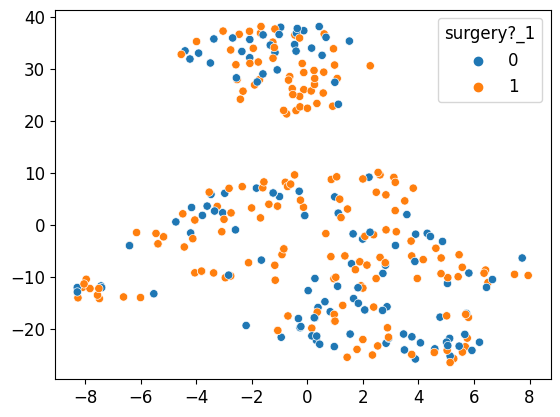

In [ ]:
X_embedded = TSNE(n_components = 2, perplexity = 28).fit_transform(X)

x_emb = X_embedded[:, 0]
y_emb = X_embedded[:, 1]

sns.scatterplot(x = x_emb, y = y_emb, hue = y)

In [ ]:
X_test.shape, y_pred.shape

((60, 123), (60,))

<Axes: >

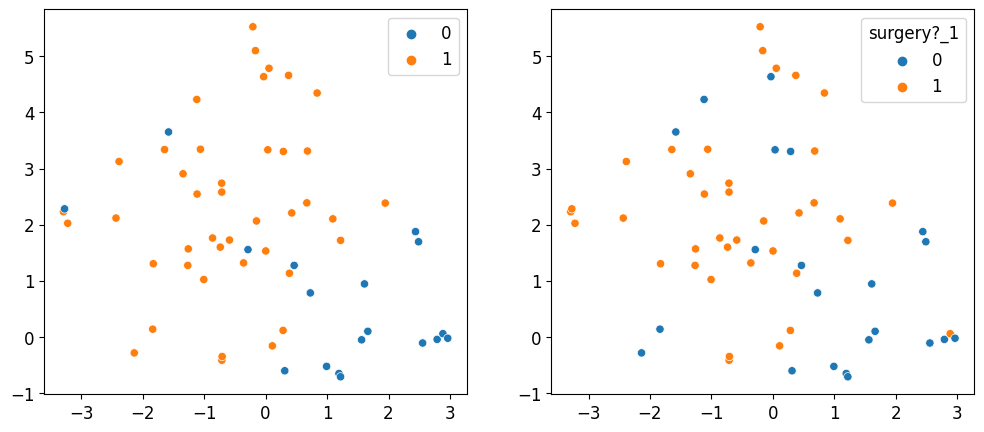

In [ ]:
X_embedded = TSNE(n_components = 2).fit_transform(X_test_n)
x_emb = X_embedded[:, 0]
y_emb = X_embedded[:, 1]

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x = x_emb, y = y_emb, hue = y_pred)

plt.subplot(1, 2, 2)
sns.scatterplot(x = x_emb, y = y_emb, hue = y_test)